# Spaceship Titanic

In the year 2912, the **Spaceship Titanic** collided with a spacetime anomaly within a dust cloud while carrying almost 13,000 passengers! Whereas the ship and about half of the passengers stayed intact, the other group of passengers were cast off to another dimension! <br><br>
For this Kaggle Competition we are attempting to predict whether passengers were cast to another dimension or not by using the records recieved from the ship's damaged computer system.


**module and package imports**


In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from utils.data_preprocessing import (
    change_spaceship_datatypes,
    create_cabin_bin_feature,
    create_family_group_feature,
    create_party_size_feature,
    create_spending_indicator_columns,
    create_split_spaceship_features,
    create_total_spending_feature,
    log_transform_spending,
    spaceship_missing_qualitative_values,
    start_pipeline,
)

**Figure Aesthetics**


In [3]:
sns.set_theme(context="notebook", style="darkgrid", palette="pastel")

## Download Data


at this point you will need to unzip the file,
if you do not have unzip on your machine and are running a macOS or linux terminal:

```
sudo get-apt install unzip
```


In [4]:
os.makedirs('../data', exist_ok=True)
!kaggle competitions download -c spaceship-titanic -p ../data
!unzip -o ../data/spaceship-titanic.zip -d ../data
os.remove('../data/spaceship-titanic.zip')

  0%|                                                | 0.00/299k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 3.27MB/s]
Archive:  ../data/spaceship-titanic.zip
  inflating: ../data/sample_submission.csv  
  inflating: ../data/test.csv        
  inflating: ../data/train.csv       


## Data Inspection and Exploratory Data Analysis


In [5]:
data_path = "../data/train.csv"
ship_data_train = pd.read_csv(data_path)
ship_data_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


What do I see at this first glance?

**PassengerID**: there are 2 numbers separated by an underscore (gggg_pp). Group followed by passenger number.<br><br>
**HomePlanet**: The Planet the person departed from. Often it is the planet of their origin<br><br>
**CryoSleep**: Boolean (True or False) Did the person choose to be in suspended animation for the entirety of their journey? <br><br>
**Cabin**: cabin number where the person stays, takes the form deck/num/side <br><br>
**Destination**: The planet the passenger will be debarking to. <br><br>
**Age**: The age of the passenger.<br><br>
**VIP**: Boolean (True or False) Whether the passenger has paid for special VIP service during the voyage. <br><br>
**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**: Amounts paid for luxury amenities <br><br>
**Name**: First Names and Last Names of Passengers <br><br>
**Transported**: Whether the passenger was transported to another dimension. This is the target column you are trying to predict.


In [6]:
ship_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Most features appear to have missing values and the datatypes are either 'object', 'float64', or 'bool'.


### Split Object-Type Features With Extra Information

note: All functions used in this notebook are found in utils module (see data_preprocessing.py)


In [7]:
spaceship_df = ship_data_train.pipe(start_pipeline).pipe(
    create_split_spaceship_features
)
spaceship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GroupID       8693 non-null   object 
 1   PassengerNum  8693 non-null   object 
 2   FirstName     8493 non-null   object 
 3   LastName      8493 non-null   object 
 4   Age           8514 non-null   float64
 5   HomePlanet    8492 non-null   object 
 6   Destination   8511 non-null   object 
 7   CabinDeck     8494 non-null   object 
 8   CabinNum      8494 non-null   object 
 9   CabinSide     8494 non-null   object 
 10  CryoSleep     8476 non-null   object 
 11  VIP           8490 non-null   object 
 12  RoomService   8512 non-null   float64
 13  FoodCourt     8510 non-null   float64
 14  ShoppingMall  8485 non-null   float64
 15  Spa           8510 non-null   float64
 16  VRDeck        8505 non-null   float64
 17  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), obje

Now we have more features (17 predictors + 1 target)<br><br>
new features: PassengerNum, FirstName, LastName, CabinDeck, CabinNum, CabinSide


### Deal with Missing Qualitative Data


In [8]:
spaceship_df.isnull().sum()

GroupID           0
PassengerNum      0
FirstName       200
LastName        200
Age             179
HomePlanet      201
Destination     182
CabinDeck       199
CabinNum        199
CabinSide       199
CryoSleep       217
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [9]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
)
spaceship_df.isnull().sum()

GroupID                 0
PassengerNum            0
FirstName               0
LastName                0
Age                   179
HomePlanet              0
Destination             0
CabinDeck               0
CabinNum                0
CabinSide               0
CryoSleep               0
VIP                     0
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Transported             0
NameMissing             0
HomeMissing             0
DestinationMissing      0
CabinMissing            0
CryoMissing             0
VIPMissing              0
dtype: int64

I have proceeded to create indicator columns for missing values as well as to call missing object-type values "Unknown" in their respective columns. <br><br>
Numerical missing values with be imputed later using some other method.


## Exploratory Data Analysis

### Transform Data For EDA

This data contains several features which can be made more specific


In [10]:
categorical_features = [
    "GroupID",
    "PassengerNum",
    "FirstName",
    "LastName",
    "HomePlanet",
    "Destination",
    "CabinDeck",
    "CabinNum",
    "CabinSide",
]
boolean_features = ["CryoSleep", "VIP"]
numerical_features = ["RoomService", "ShoppingMall", "Spa", "VRDeck"]
integer_features = ["Age"]
indicator_features = [
    "NameMissing",
    "HomeMissing",
    "DestinationMissing",
    "CabinMissing",
    "CryoMissing",
    "VIPMissing",
]
target_feature = "Transported"

In [11]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
)
spaceship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GroupID             8693 non-null   category
 1   PassengerNum        8693 non-null   category
 2   FirstName           8693 non-null   category
 3   LastName            8693 non-null   category
 4   Age                 8514 non-null   Int64   
 5   HomePlanet          8693 non-null   category
 6   Destination         8693 non-null   category
 7   CabinDeck           8693 non-null   category
 8   CabinNum            8693 non-null   category
 9   CabinSide           8693 non-null   category
 10  CryoSleep           8693 non-null   category
 11  VIP                 8693 non-null   category
 12  RoomService         8512 non-null   float64 
 13  FoodCourt           8510 non-null   float64 
 14  ShoppingMall        8485 non-null   float64 
 15  Spa                 8510 non-null   fl

### Categorical Features


In [12]:
spaceship_df[categorical_features + boolean_features + indicator_features].describe()

,GroupID,PassengerNum,FirstName,LastName,HomePlanet,Destination,CabinDeck,CabinNum,CabinSide,CryoSleep,VIP,NameMissing,HomeMissing,DestinationMissing,CabinMissing,CryoMissing,VIPMissing
count,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693
unique,6217,8,2707,2218,4,4,9,1818,3,3,3,2,2,2,2,2,2
top,4498,01,Unknown,Unknown,Earth,TRAPPIST-1e,F,Unknown,S,False,False,False,False,False,False,False,False
freq,8,6217,200,200,4602,5915,2794,199,4288,5439,8291,8493,8492,8511,8494,8476,8490


Notice:

- None of these features contain missing values
- Some Features have high cardinality
- Some Features have very common values


Deal with High-Cardinality Variables\_\_


In [13]:
print(
    f"There are {len(spaceship_df['GroupID'].unique())} unique GroupIDs in this dataset."
)

There are 6217 unique GroupIDs in this dataset.


How to deal with that many groups?

- create a feature called "PartySize" (i.e. find the size of each group and assign this to the entire group)


In [14]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
    .pipe(create_party_size_feature)
)

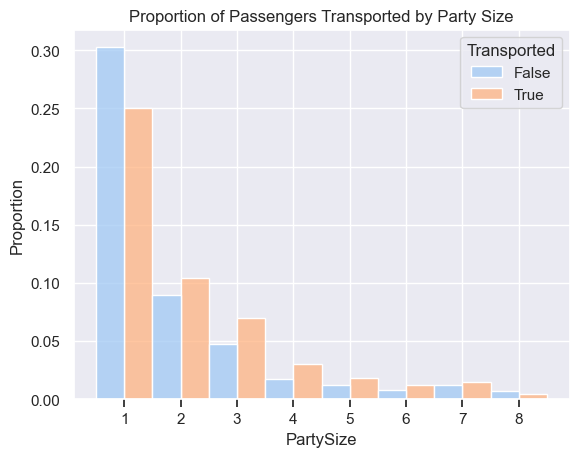

In [15]:
ax = sns.histplot(
    data=spaceship_df,
    x="PartySize",
    hue="Transported",
    stat="proportion",
    discrete=True,
    multiple="dodge",
)
plt.tick_params(axis="x", which="both", bottom=True, top=False)
plt.title("Proportion of Passengers Transported by Party Size")
plt.show()

It does appear that the size of the party might have some relationship to whether a passenger was Transported or not, but let's assess this more rigorously.

note: ALL STATISTICAL TESTS PERFORMED IN THIS EDA WILL USE AN ALPHA-LEVEL=0.05


In [16]:
party_size_contingency = pd.crosstab(
    spaceship_df["Transported"], spaceship_df["PartySize"]
)
party_size_contingency

PartySize,1,2,3,4,5,6,7,8
Transported,,,,,,,,
False,2631,777,415,148,108,67,106,63
True,2174,905,605,264,157,107,125,41


In [17]:
chi2, p, _, _ = stats.chi2_contingency(
    pd.crosstab(spaceship_df["Transported"], spaceship_df["PartySize"])
)

print(
    f"The distribution of passengers transported by party size differs from the expected frequency with a Chi-Square statistic of {chi2:.2f} and a p-value of {p:.5f} (i.e. less than .05)."
)

The distribution of passengers transported by party size differs from the expected frequency with a Chi-Square statistic of 145.28 and a p-value of 0.00000 (i.e. less than .05).


Names are also unique identifiers, so I can create a boolean if groups have the same last name

- for each last name, if LastName and GroupID are the same, then we will call them Family Members


In [18]:
print(
    f"There are {len(ship_data_train['Name'].unique())} unique names in this dataset."
)

There are 8474 unique names in this dataset.


In [19]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
    .pipe(create_party_size_feature)
    .pipe(create_family_group_feature)
)

In [20]:
spaceship_df.loc[
    (spaceship_df["FamilyGroupMember"] == True) & (spaceship_df["NameMissing"] == True),
    :,
]

,GroupID,PassengerNum,FirstName,LastName,Age,HomePlanet,Destination,CabinDeck,CabinNum,CabinSide,...,VRDeck,Transported,NameMissing,HomeMissing,DestinationMissing,CabinMissing,CryoMissing,VIPMissing,PartySize,FamilyGroupMember


there are no Family Group members with missing names to consider


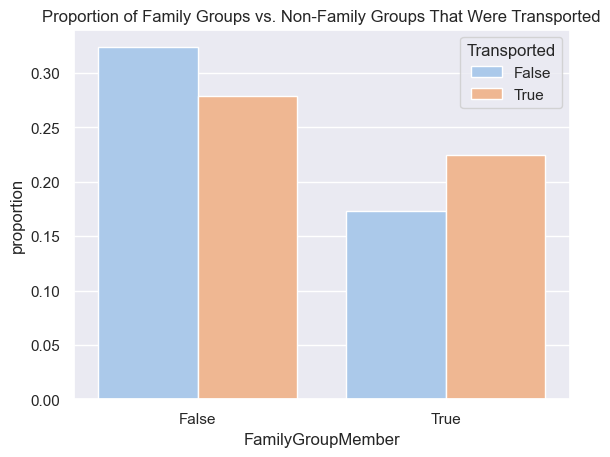

In [21]:
sns.countplot(spaceship_df, x="FamilyGroupMember", hue="Transported", stat="proportion")
plt.title("Proportion of Family Groups vs. Non-Family Groups That Were Transported")
plt.show()

Whether a group is a family or not also appears like might be a meaningful predictor of whether a passenger was transported.


In [22]:
family_group_contingency = pd.crosstab(
    spaceship_df["Transported"], spaceship_df["FamilyGroupMember"]
)
family_group_contingency

FamilyGroupMember,False,True
Transported,,
False,2814,1501
True,2426,1952


In [23]:
chi2, p, _, _ = stats.chi2_contingency(family_group_contingency)
print(
    f"The distribution of passengers transported by whether they traveled with family or not differs from the expected frequency with a Chi-Square statistic of {chi2:.2f} and a p-value of {p:.5f} (i.e. less than .05)."
)

The distribution of passengers transported by whether they traveled with family or not differs from the expected frequency with a Chi-Square statistic of 86.77 and a p-value of 0.00000 (i.e. less than .05).


Hence, this might be a useful predictor to use for machine learning.


The last high cardinality feature that I am not sure how to deal with is CabinNum, so I will try a few different things:

- compare random samples
- odds vs evens
- binning

if none of these show any trend then I will drop the feature


In [24]:
cabin_num_temp = spaceship_df[["CabinNum", "Transported"]]
cabin_num_temp.CabinNum = pd.to_numeric(cabin_num_temp.CabinNum, errors="coerce")

/var/folders/fw/n97s2lw13v7d0brxq53jt7xh0000gn/T/ipykernel_50755/1815617076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabin_num_temp.CabinNum = pd.to_numeric(cabin_num_temp.CabinNum, errors="coerce")


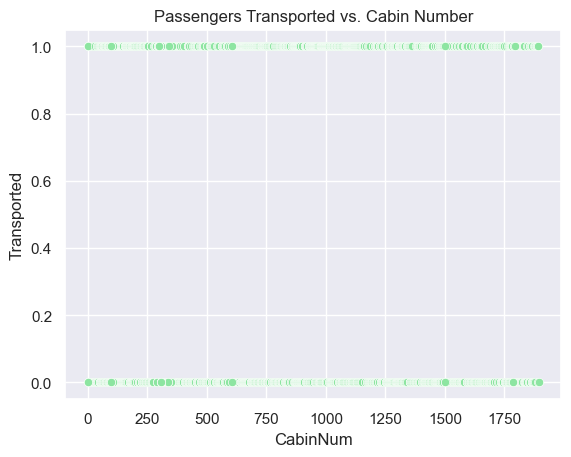

In [25]:
sns.scatterplot(data=cabin_num_temp, x="CabinNum", y="Transported", color="g")
plt.title("Passengers Transported vs. Cabin Number")
plt.show()

There does not appear to be an obvious trend based on cabin number, but let's investigate more systematically.


In [26]:
cabin_num_temp.describe()

,CabinNum
count,8494.000000
mean,600.367671
std,511.867226
min,0.000000
25%,167.250000
50%,427.000000
75%,999.000000
max,1894.000000


What does this trend look like if we randomly split the data into 5 random bins?


In [27]:
rand_sample_array = np.array_split(cabin_num_temp.sample(8000), 5)
for df in rand_sample_array:
    print(df["Transported"].value_counts())

Transported
False    822
True     778
Name: count, dtype: int64
Transported
True     811
False    789
Name: count, dtype: int64
Transported
True     806
False    794
Name: count, dtype: int64
Transported
True     812
False    788
Name: count, dtype: int64
Transported
True     841
False    759
Name: count, dtype: int64


/Users/migueldiaz/Documents/datascience/projects_for_github/spaceship_titanic_prediction/spaceship_titanic/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [28]:
rand_sample_array = np.array_split(cabin_num_temp.sample(8000), 5)
random_cabin_counts_list = [
    df["Transported"].value_counts() for df in rand_sample_array
]
random_cabin_counts_contingency = (
    pd.concat(random_cabin_counts_list, axis=1).fillna(0).astype(int)
)
stat, p, _, _ = stats.chi2_contingency(random_cabin_counts_contingency)
print(
    f"Splitting the data into random bins based on cabin number differs from expectation with a Chi-Squared Statistic of {stat:.2f} and a p-value of {p:.5f}."
)

Splitting the data into random bins based on cabin number differs from expectation with a Chi-Squared Statistic of 1.54 and a p-value of 0.81899.


Looking at just random splits of the data, it does not appear like there is a trend in the data.

How about evens and odds?


In [29]:
evens = cabin_num_temp[cabin_num_temp["CabinNum"].values % 2 == 0]
odds = cabin_num_temp[cabin_num_temp["CabinNum"].values % 2 != 0]
evens_counts = evens["Transported"].value_counts()
odds_counts = odds["Transported"].value_counts()
even_odds_contingency = pd.concat([evens_counts, odds_counts], axis=1)
stat, p, _, _ = stats.chi2_contingency(even_odds_contingency)
print(
    f"Splitting the data into bins of odd and even cabin numbers differs from expectation with a Chi-Squared Statistic of {stat:.2f} and a p-value of {p:.5f}."
)

Splitting the data into bins of odd and even cabin numbers differs from expectation with a Chi-Squared Statistic of 2.16 and a p-value of 0.14150.


There is not a clearly significant trend for even vs. odd cabin numbers. <br><br>
What if we create an ascending binning of the cabin numbers?


In [30]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
    .pipe(create_party_size_feature)
    .pipe(create_family_group_feature)
    .pipe(create_cabin_bin_feature, n_bins=5)
)

In [31]:
cabin_bin_temp = spaceship_df[["CabinBin", "Transported"]]
cabin_bins_transported = cabin_bin_temp.groupby("CabinBin").value_counts()
cabin_bins_contingency = cabin_bins_transported.reset_index().pivot(
    index="CabinBin", columns="Transported", values="count"
)
cabin_bins_contingency

Transported,False,True
CabinBin,,
0.0,796,907
1.0,775,922
2.0,970,726
3.0,705,997
4.0,970,726


In [32]:
chi2, p, _, _ = stats.chi2_contingency(cabin_bins_contingency)
print(
    f"Splitting the data into ascending bins based on cabin number differs from expectation with a Chi-Squared Statistic of {chi2:.2f} and a p-value of {p:.5f} (i.e. less than .05)."
)

Splitting the data into ascending bins based on cabin number differs from expectation with a Chi-Squared Statistic of 139.83 and a p-value of 0.00000 (i.e. less than .05).


Using ordinally encoded bins seems like a viable solution for machine learning.


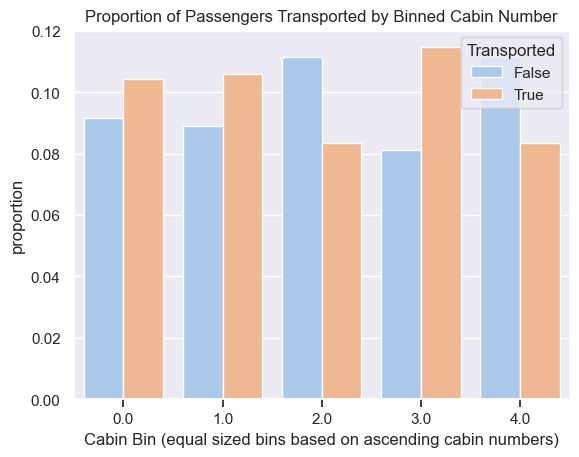

In [33]:
sns.countplot(cabin_bin_temp, x="CabinBin", hue="Transported", stat="proportion")
plt.tick_params(axis="x", which="both", bottom=True, top=False)
plt.title("Proportion of Passengers Transported by Binned Cabin Number")
plt.xlabel("Cabin Bin (equal sized bins based on ascending cabin numbers)")
plt.show()

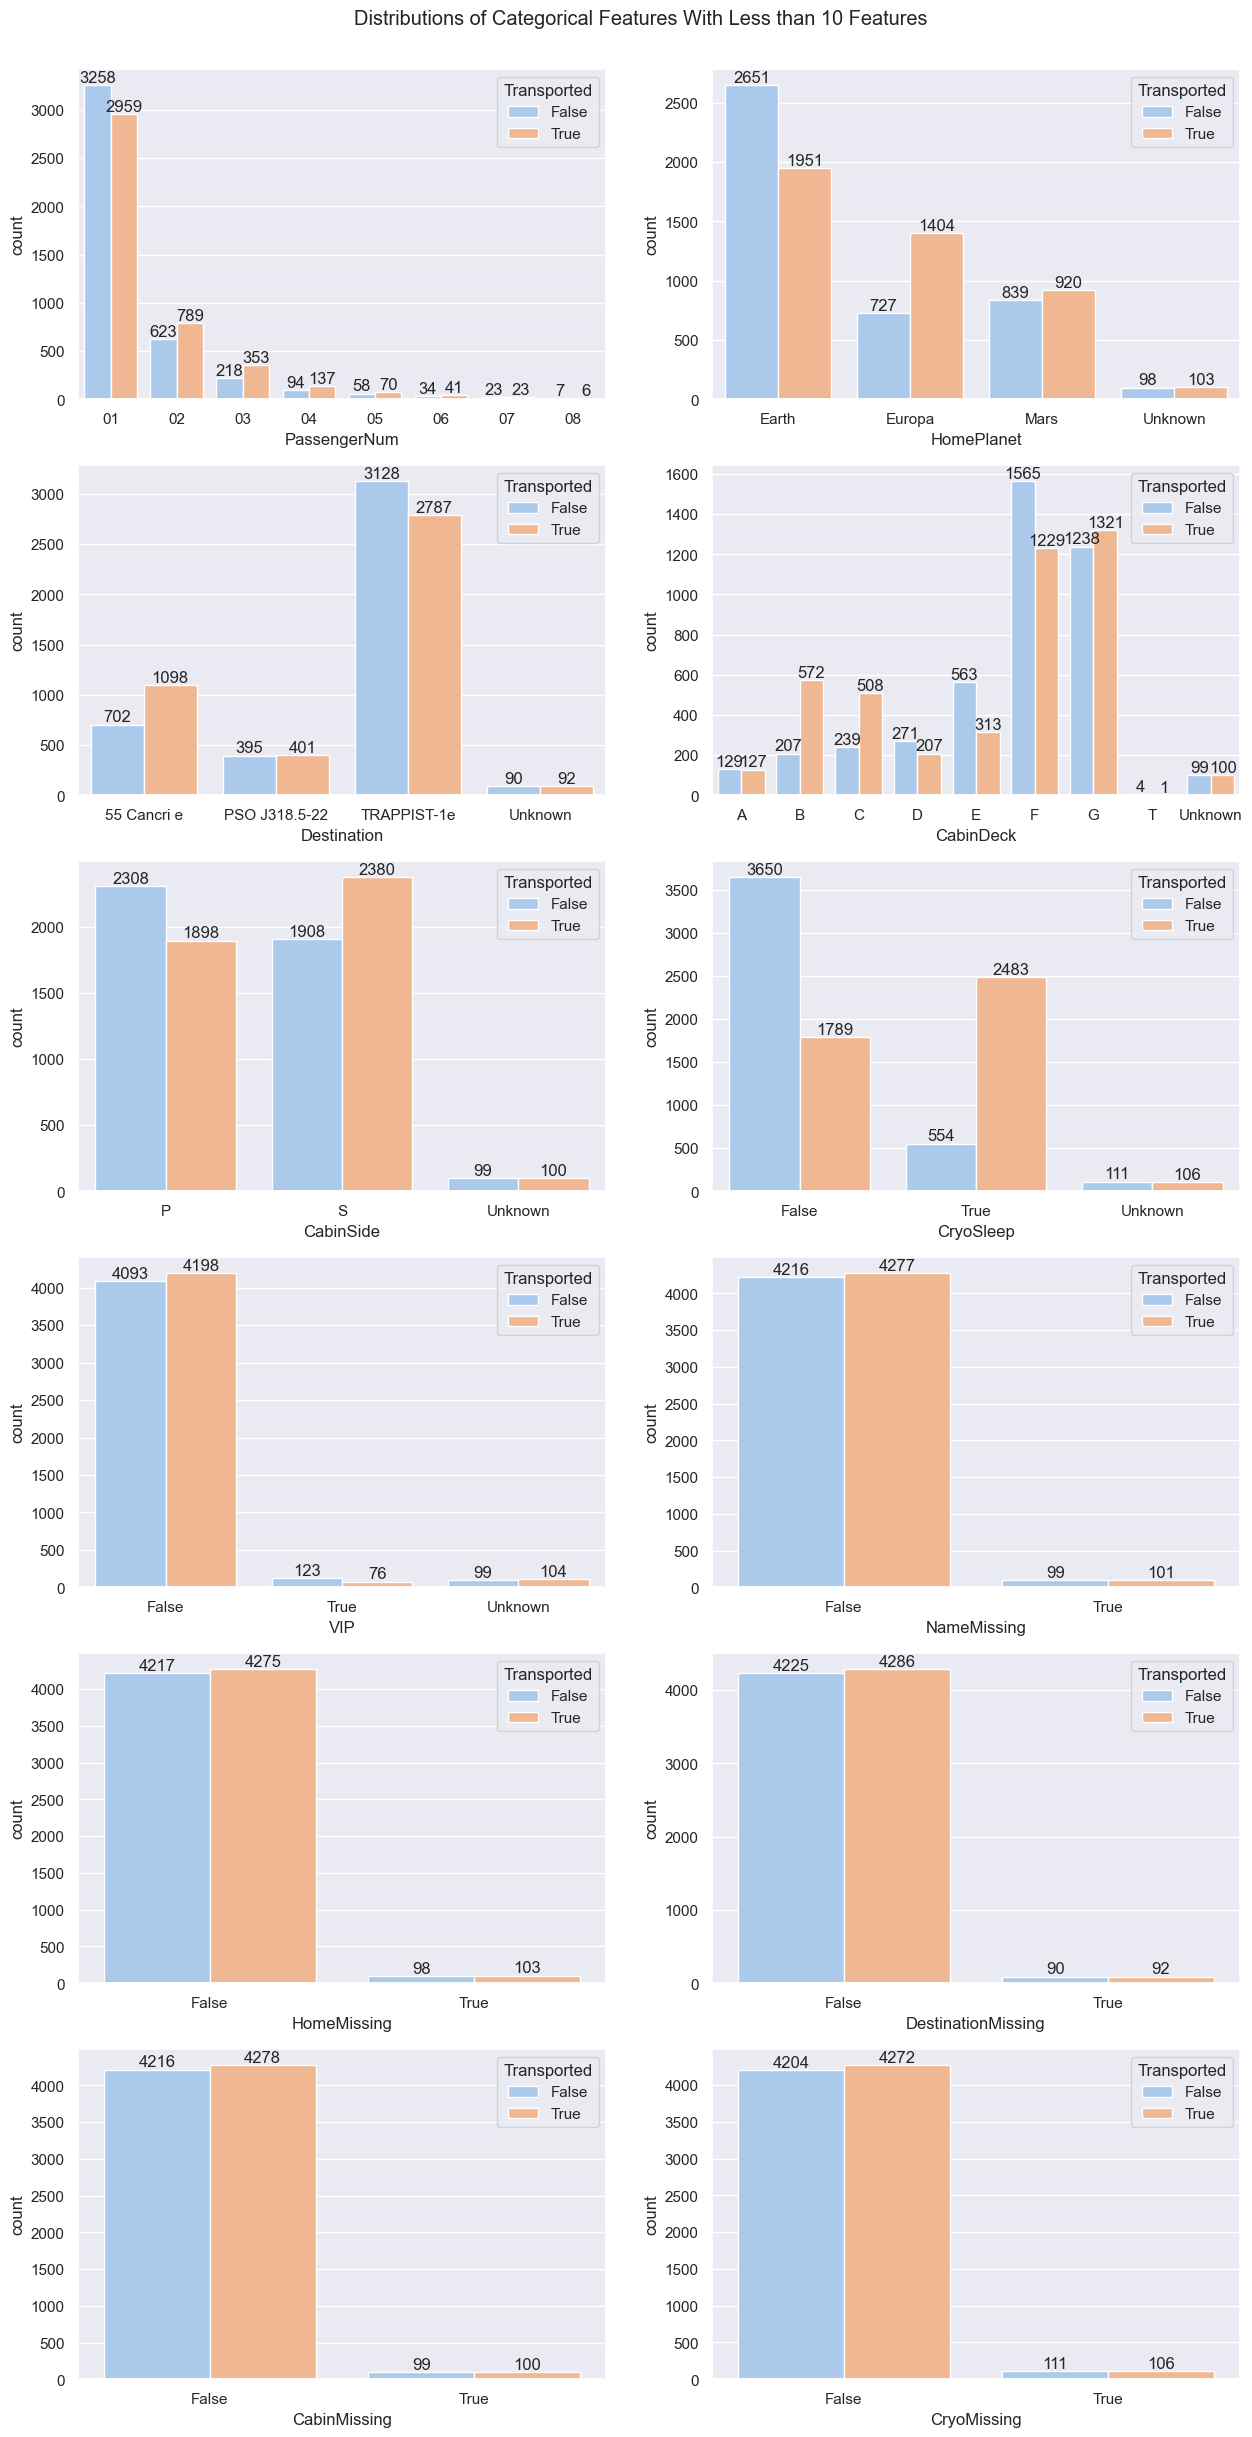

In [34]:
cols_for_cat_plot = [
    "PassengerNum",
    "HomePlanet",
    "Destination",
    "CabinDeck",
    "CabinSide",
    "CryoSleep",
    "VIP",
    "NameMissing",
    "HomeMissing",
    "DestinationMissing",
    "CabinMissing",
    "CryoMissing",
    "VIPMissing",
]
fig, ax = plt.subplots(int(len(cols_for_cat_plot) / 2), 2, figsize=(15, 30))
for i, subplots in zip(cols_for_cat_plot, ax.flatten()):
    sns.countplot(
        x=spaceship_df[i],
        hue=spaceship_df[target_feature],
        ax=subplots,
    )
    for container in subplots.containers:
        subplots.bar_label(container)
plt.suptitle("Distributions of Categorical Features With Less than 10 Features", y=0.9)
plt.show()

### Numerical Features


In [35]:
spaceship_df["TotalSpending"] = spaceship_df[
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].sum(axis=1, skipna=False)

In [36]:
all_numerical_features = [
    "Age",
    "RoomService",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "PartySize",
    "TotalSpending",
]

In [37]:
spaceship_df[all_numerical_features].describe()

,Age,RoomService,ShoppingMall,Spa,VRDeck,PartySize,TotalSpending
count,8514.0,8512.000000,8485.000000,8510.000000,8505.000000,8693.000000,7785.000000
mean,28.82793,224.687617,173.729169,311.138778,304.854791,2.035546,1484.601541
std,14.489021,666.717663,604.696458,1136.705535,1145.717189,1.596347,2845.288241
min,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,19.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.0,0.000000,0.000000,0.000000,0.000000,1.000000,736.000000
75%,38.0,47.000000,27.000000,59.000000,46.000000,3.000000,1486.000000
max,79.0,14327.000000,23492.000000,22408.000000,24133.000000,8.000000,35987.000000


Looking at numerical features, notice:

- all features except for Age and PartySize represent spending of money on luxury items.
- I have created a "TotalSpending" column to sum values in all luxury spending columns.
- Age and PartySize are best represented by discrete integer values
- All numerical columns have missing values
- The scale of each column varies


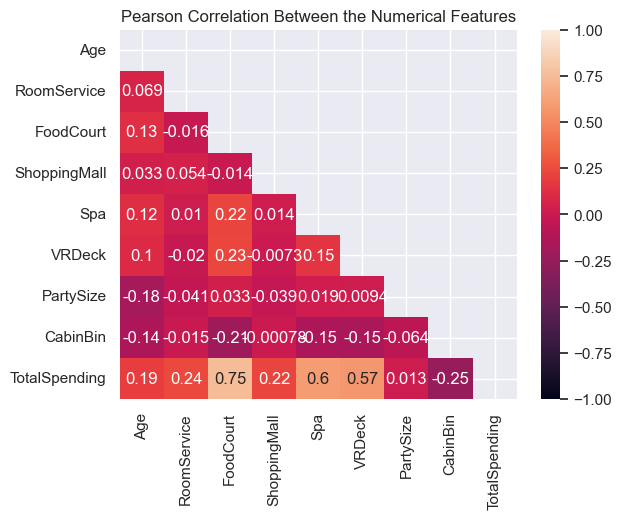

In [38]:
corr = spaceship_df.select_dtypes(include="number").corr()
mask = np.triu(corr)
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=mask)
plt.title("Pearson Correlation Between the Numerical Features")
plt.show()

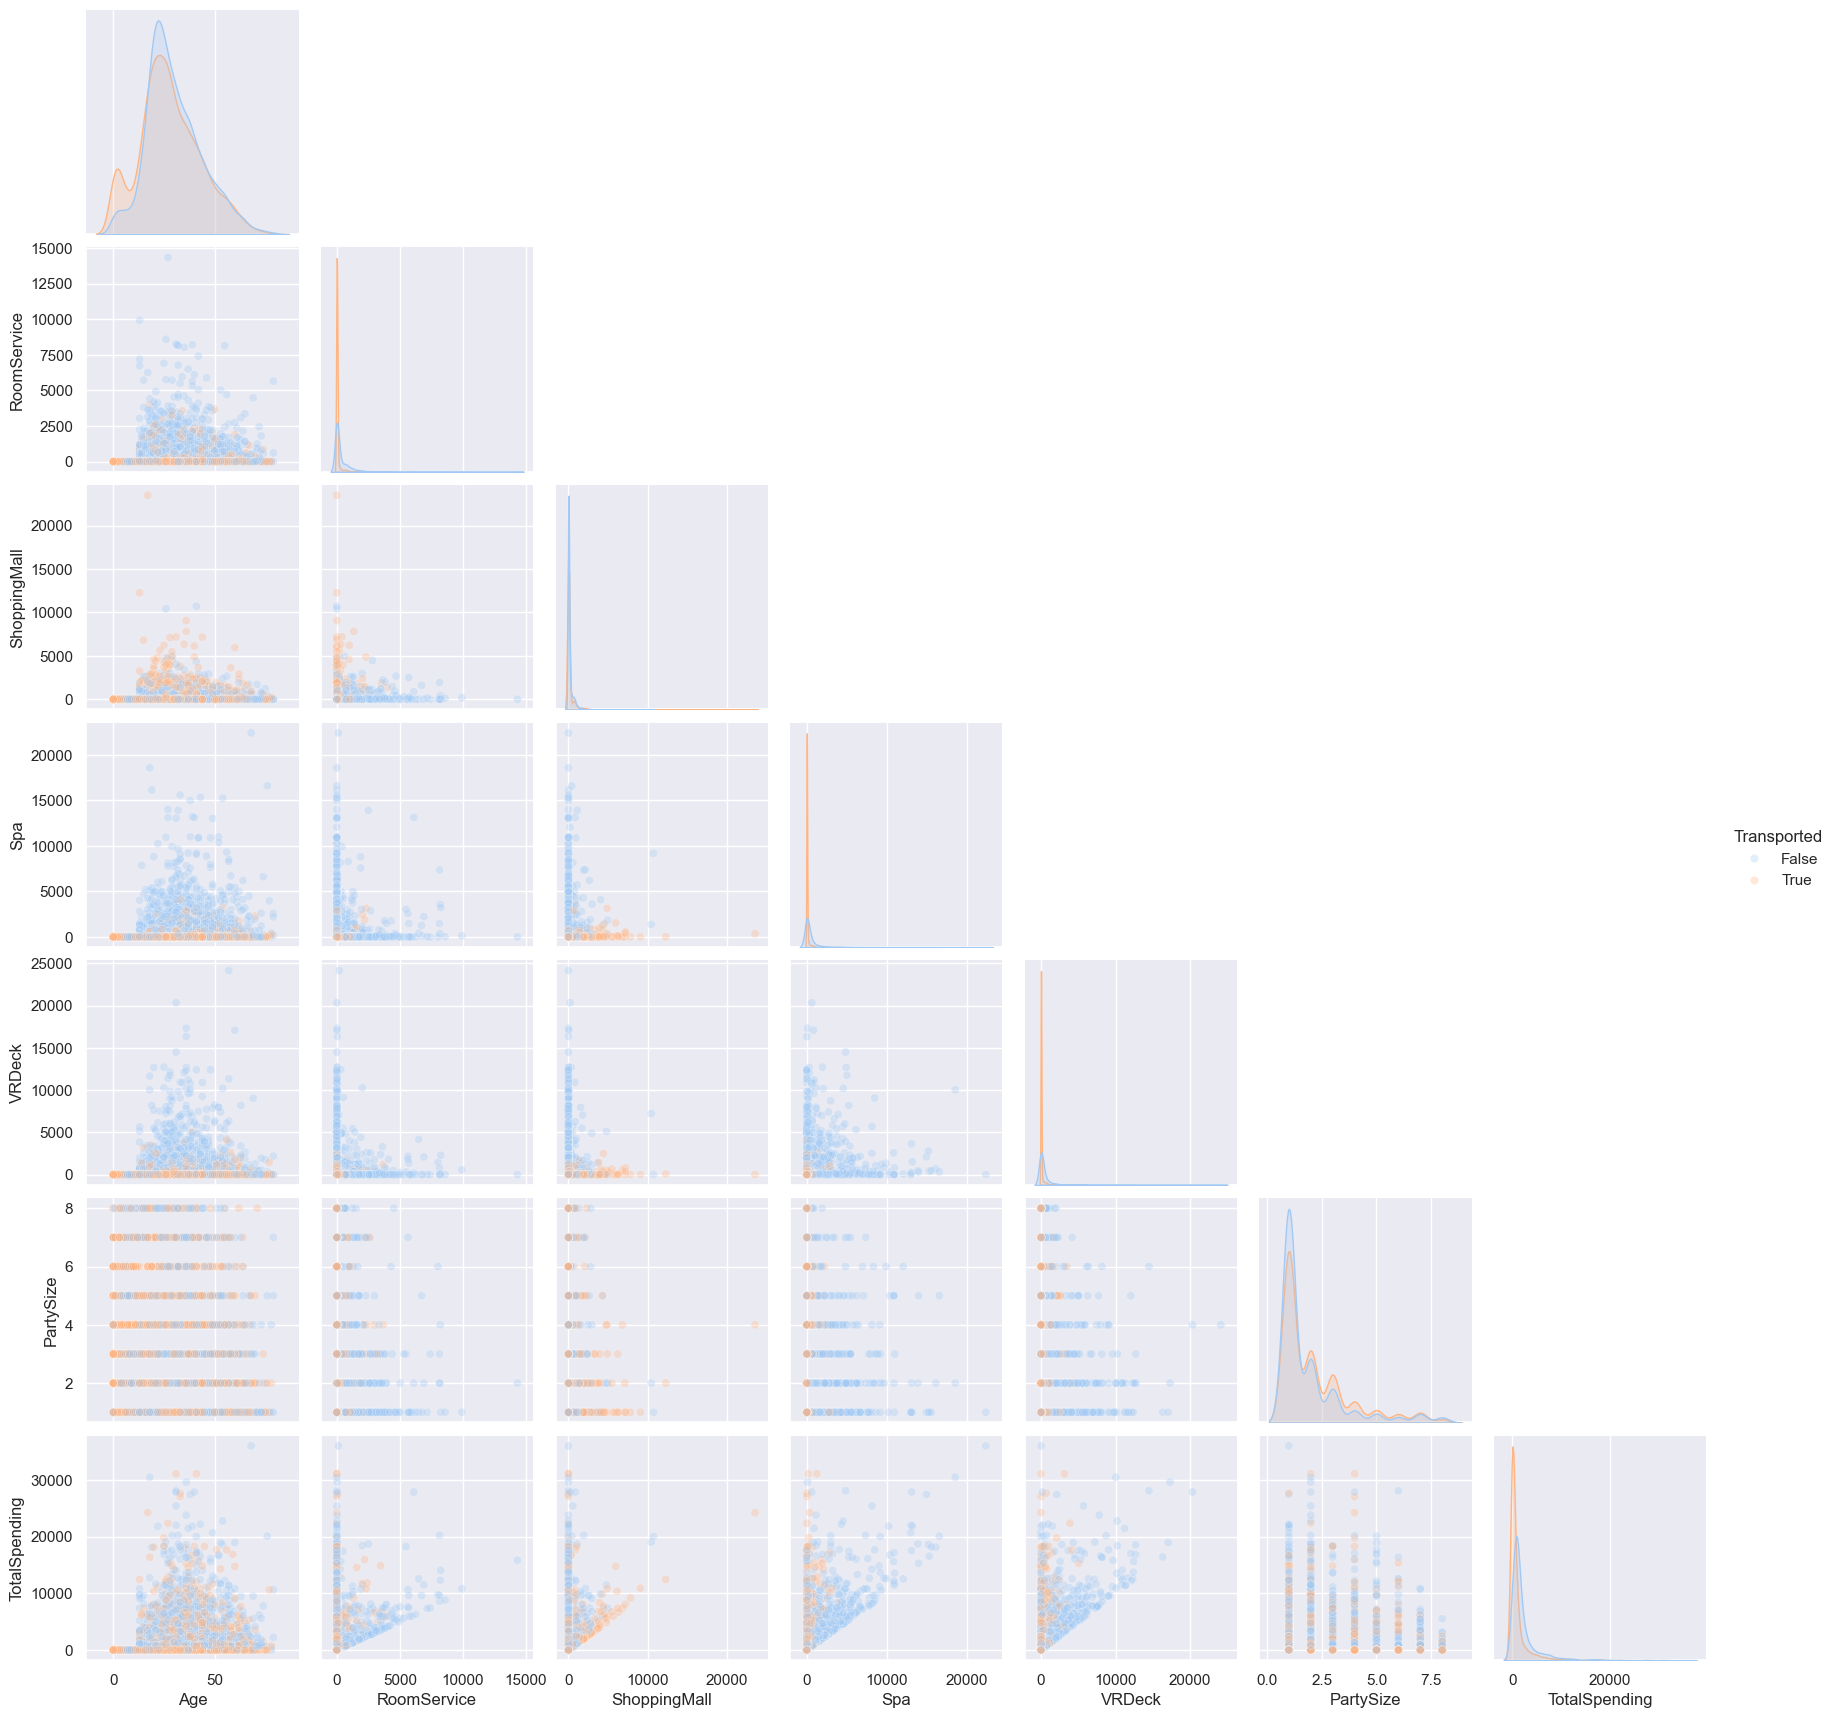

In [39]:
ax = sns.pairplot(
    spaceship_df,
    vars=all_numerical_features,
    hue="Transported",
    corner=True,
    plot_kws={"alpha": 0.3},
)

notice:

- TotalSpending correlates with all spending columns (and age) and this might cause a problem of collinearity for machine learning algorithms (hence this might not be a useful feature for prediction)
- Other columns do not have a strong correlation


#### Age


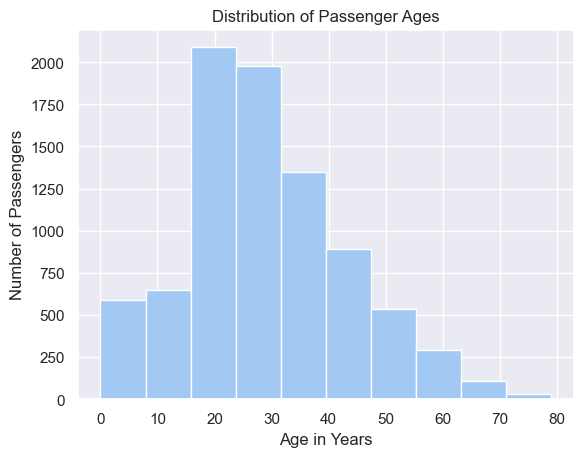

In [40]:
spaceship_df["Age"].hist()
plt.title("Distribution of Passenger Ages")
plt.xlabel("Age in Years")
plt.ylabel("Number of Passengers")
plt.show()

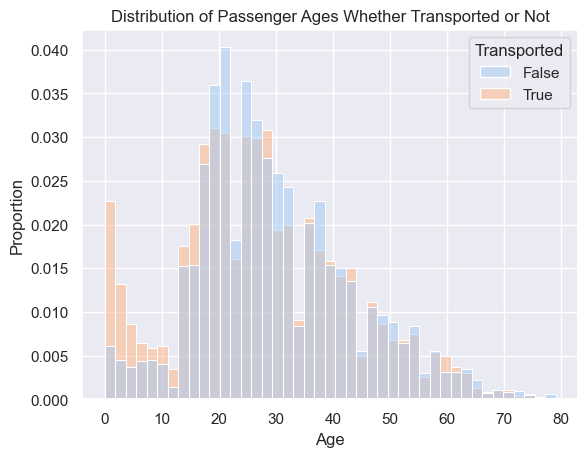

In [41]:
sns.histplot(data=spaceship_df, x="Age", hue="Transported", stat="proportion")
plt.title("Distribution of Passenger Ages Whether Transported or Not")
plt.show()

#### PartySize


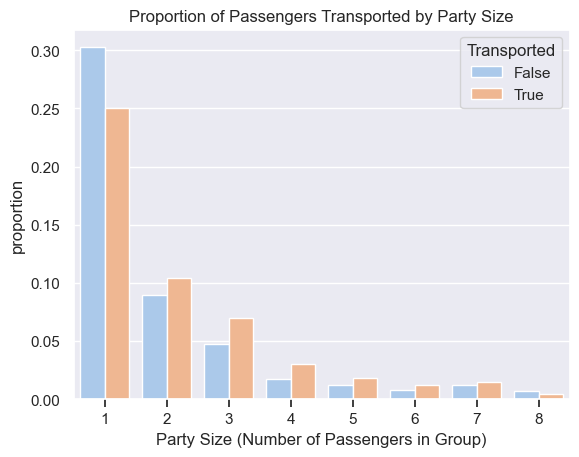

In [42]:
sns.countplot(spaceship_df, x="PartySize", hue="Transported", stat="proportion")
plt.tick_params(axis="x", which="both", bottom=True, top=False)
plt.title("Proportion of Passengers Transported by Party Size")
plt.xlabel("Party Size (Number of Passengers in Group)")
plt.show()

#### Luxury Spending


<Axes: >

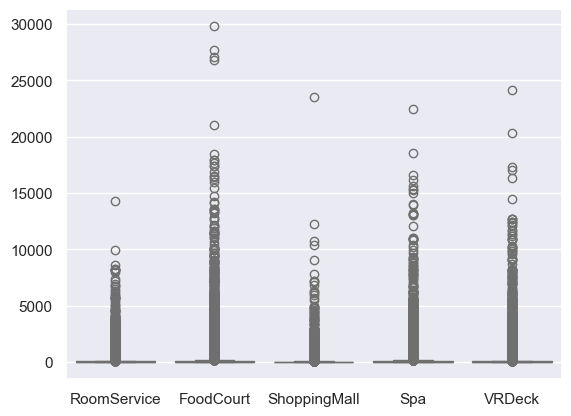

In [43]:
sns.boxplot(spaceship_df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])

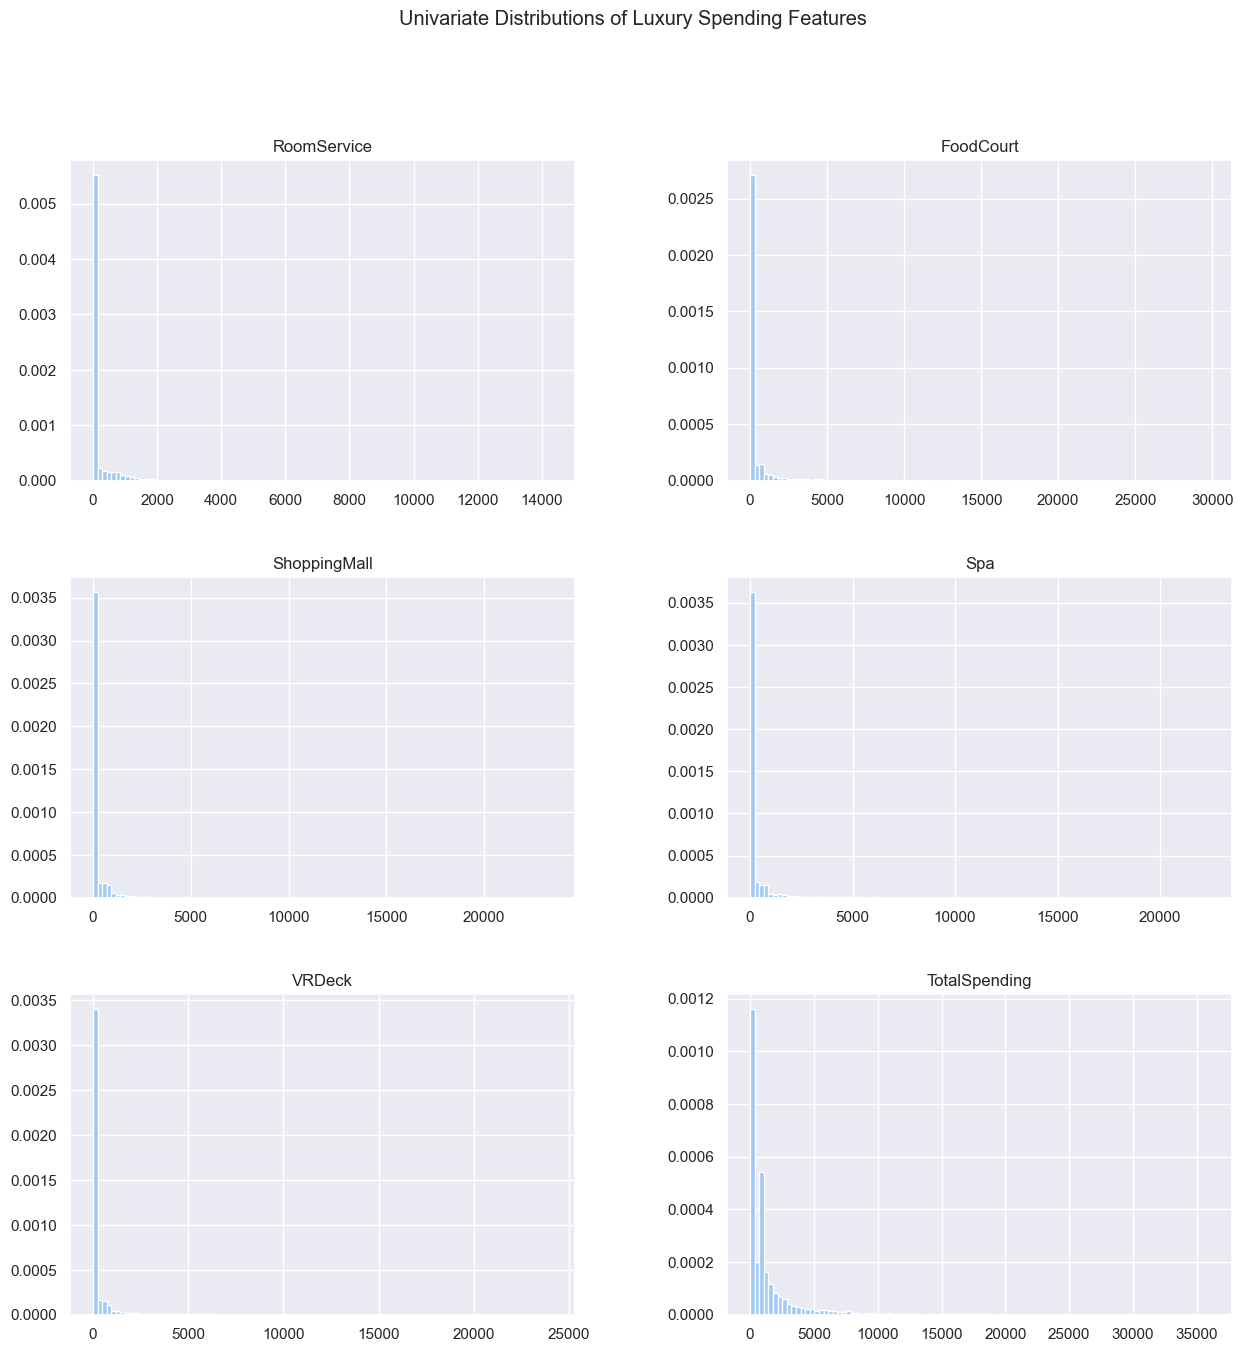

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
spaceship_spending_df = spaceship_df[
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpending"]
]
spaceship_spending_df.hist(bins=100, density=True, ax=ax)
plt.suptitle("Univariate Distributions of Luxury Spending Features")
plt.show()

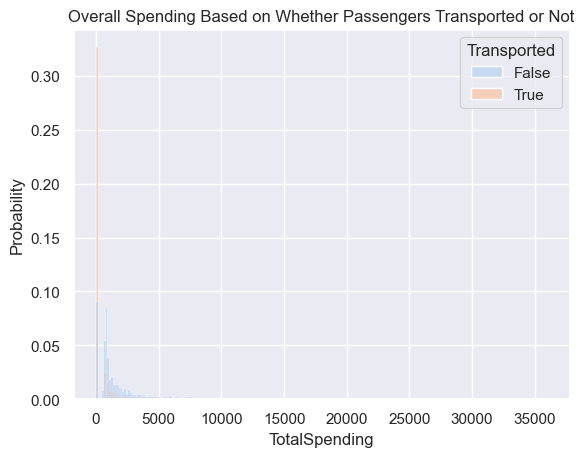

In [45]:
sns.histplot(
    data=spaceship_df, x="TotalSpending", hue="Transported", stat="probability"
)
plt.title("Overall Spending Based on Whether Passengers Transported or Not")
plt.show()

A few observations:

- most values are zero
- all distributions have a rightward skew

My solution:

- create an indicator variable for each column "Yes[colname]" (Boolean)
- log transform the data using np.log1p function and place values in "Log[colname]"

Note:

- I will note deal with putative outliers because the range of spending features (and other numerical features) does not appear to be particularly abnormal and is mostly dominated by zero spending which I am using an indicator column to deal with


In [46]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
    .pipe(create_party_size_feature)
    .pipe(create_family_group_feature)
    .pipe(create_cabin_bin_feature, n_bins=5)
    .pipe(create_total_spending_feature)
    .pipe(create_spending_indicator_columns)
    .pipe(log_transform_spending)
)
spaceship_df

,GroupID,PassengerNum,FirstName,LastName,Age,HomePlanet,Destination,CabinDeck,CabinNum,CabinSide,...,YesShoppingMall,YesSpa,YesVRDeck,YesTotalSpending,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck,LogTotalSpending
0,0001,01,Maham,Ofracculy,39,Europa,TRAPPIST-1e,B,0,P,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0002,01,Juanna,Vines,24,Earth,TRAPPIST-1e,F,0,S,...,True,True,True,True,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588
2,0003,01,Altark,Susent,58,Europa,TRAPPIST-1e,A,0,S,...,False,True,True,True,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021
3,0003,02,Solam,Susent,33,Europa,TRAPPIST-1e,A,0,S,...,True,True,True,True,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981
4,0004,01,Willy,Santantines,16,Earth,TRAPPIST-1e,F,1,S,...,True,True,True,True,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,01,Gravior,Noxnuther,41,Europa,55 Cancri e,A,98,P,...,False,True,True,True,0.000000,8.827615,0.000000,7.404888,4.317488,9.052165
8689,9278,01,Kurta,Mondalley,18,Earth,PSO J318.5-22,G,1499,S,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8690,9279,01,Fayey,Connon,26,Earth,TRAPPIST-1e,G,1500,S,...,True,True,False,True,0.000000,0.000000,7.535297,0.693147,0.000000,7.535830
8691,9280,01,Celeon,Hontichre,32,Europa,55 Cancri e,E,608,S,...,False,True,True,True,0.000000,6.956545,0.000000,5.869297,8.082093,8.442039


Now to assess these spending trends on the log scale without the 0 values to see the nature of these log transformations which we may or may not use for predictive modeling based on model performance.


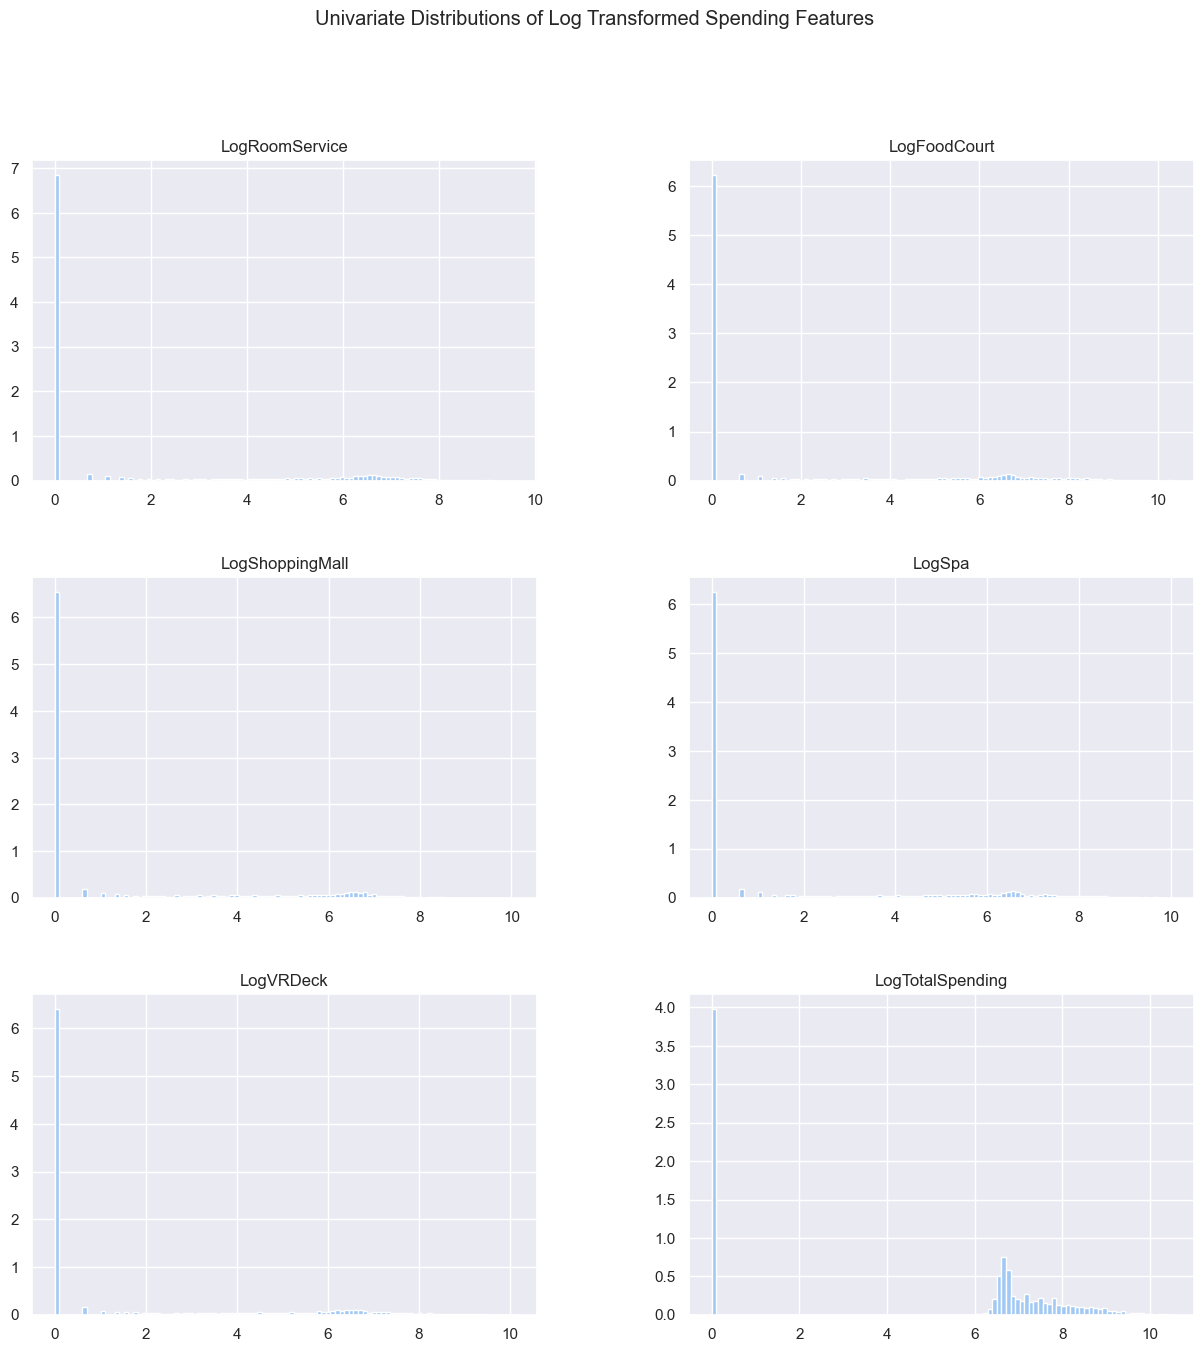

In [47]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
log_spaceship_spending_df = spaceship_df[
    [
        "LogRoomService",
        "LogFoodCourt",
        "LogShoppingMall",
        "LogSpa",
        "LogVRDeck",
        "LogTotalSpending",
    ]
]
log_spaceship_spending_df.hist(bins=100, density=True, ax=ax)
plt.suptitle("Univariate Distributions of Log Transformed Spending Features")
plt.show()

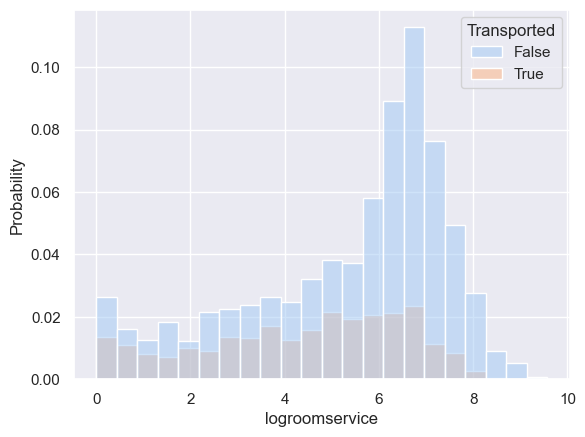

In [48]:
df = spaceship_df.copy()
df["logroomservice"] = df["RoomService"].apply(np.log)
sns.histplot(data=df, x="logroomservice", hue="Transported", stat="probability")
plt.show()

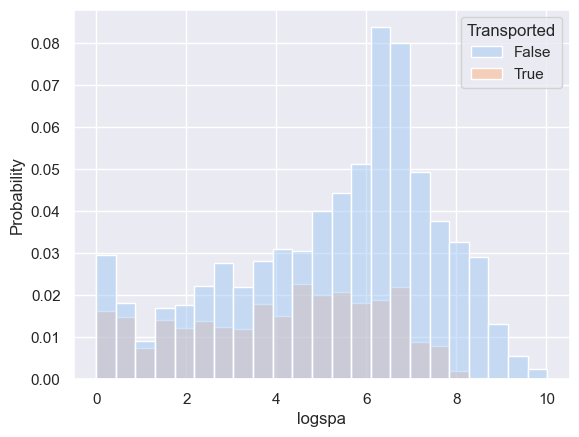

In [49]:
df = spaceship_df.copy()
df["logspa"] = df["Spa"].apply(np.log)
sns.histplot(data=df, x="logspa", hue="Transported", stat="probability")
plt.show()

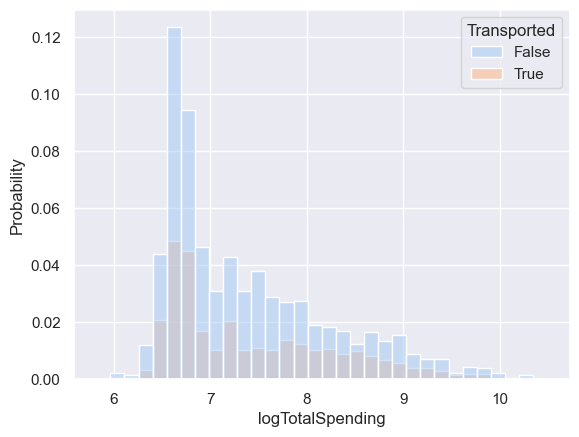

In [50]:
df = spaceship_df.copy()
df["logTotalSpending"] = df["TotalSpending"].apply(np.log)
sns.histplot(data=df, x="logTotalSpending", hue="Transported", stat="probability")
plt.show()

We will use the performance of our models to determine whether log transforms such as seen in these plots are worth using as features.


### Target Feature


In [51]:
target_feature = "Transported"

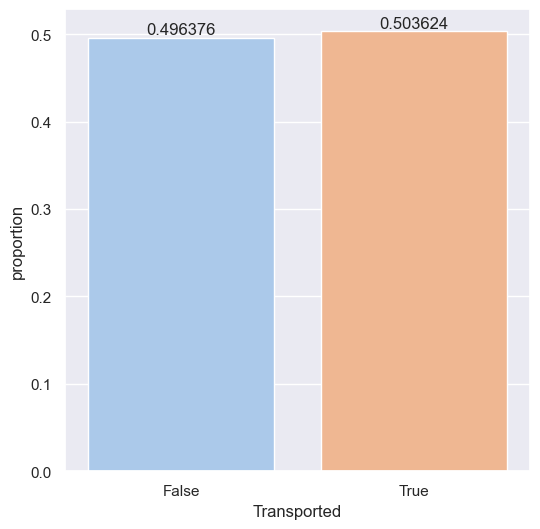

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.countplot(
    x=spaceship_df[target_feature],
    hue=spaceship_df[target_feature],
    ax=ax,
    stat="proportion",
    legend=False,
)
for container in ax.containers:
    ax.bar_label(container)

In general, the training data appears be balanced relative to the target class


Full data pre-processing pipeline:


In [57]:
spaceship_df = (
    ship_data_train.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
    .pipe(create_party_size_feature)
    .pipe(create_family_group_feature)
    .pipe(create_cabin_bin_feature, n_bins=5)
    .pipe(create_total_spending_feature)
    .pipe(create_spending_indicator_columns)
    .pipe(log_transform_spending)
)
all_cat_features = list(spaceship_df.select_dtypes(include=["bool", "category"]))
all_num_features = list(spaceship_df.select_dtypes(include="number"))
spaceship_df = change_spaceship_datatypes(
    spaceship_df,
    cat_features=all_cat_features,
    cat_to="str",
    float_features=all_num_features,
    float_to="float64",
)
spaceship_df

,GroupID,PassengerNum,FirstName,LastName,Age,HomePlanet,Destination,CabinDeck,CabinNum,CabinSide,...,YesShoppingMall,YesSpa,YesVRDeck,YesTotalSpending,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck,LogTotalSpending
0,0001,01,Maham,Ofracculy,39.0,Europa,TRAPPIST-1e,B,0,P,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0002,01,Juanna,Vines,24.0,Earth,TRAPPIST-1e,F,0,S,...,True,True,True,True,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588
2,0003,01,Altark,Susent,58.0,Europa,TRAPPIST-1e,A,0,S,...,False,True,True,True,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021
3,0003,02,Solam,Susent,33.0,Europa,TRAPPIST-1e,A,0,S,...,True,True,True,True,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981
4,0004,01,Willy,Santantines,16.0,Earth,TRAPPIST-1e,F,1,S,...,True,True,True,True,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,01,Gravior,Noxnuther,41.0,Europa,55 Cancri e,A,98,P,...,False,True,True,True,0.000000,8.827615,0.000000,7.404888,4.317488,9.052165
8689,9278,01,Kurta,Mondalley,18.0,Earth,PSO J318.5-22,G,1499,S,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8690,9279,01,Fayey,Connon,26.0,Earth,TRAPPIST-1e,G,1500,S,...,True,True,False,True,0.000000,0.000000,7.535297,0.693147,0.000000,7.535830
8691,9280,01,Celeon,Hontichre,32.0,Europa,55 Cancri e,E,608,S,...,False,True,True,True,0.000000,6.956545,0.000000,5.869297,8.082093,8.442039


In [58]:
spaceship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GroupID             8693 non-null   object 
 1   PassengerNum        8693 non-null   object 
 2   FirstName           8693 non-null   object 
 3   LastName            8693 non-null   object 
 4   Age                 8514 non-null   float64
 5   HomePlanet          8693 non-null   object 
 6   Destination         8693 non-null   object 
 7   CabinDeck           8693 non-null   object 
 8   CabinNum            8693 non-null   object 
 9   CabinSide           8693 non-null   object 
 10  CryoSleep           8693 non-null   object 
 11  VIP                 8693 non-null   object 
 12  RoomService         8512 non-null   float64
 13  FoodCourt           8510 non-null   float64
 14  ShoppingMall        8485 non-null   float64
 15  Spa                 8510 non-null   float64
 16  VRDeck

I will also drop the very high cardinality features since they will not be used for any modeling.


In [59]:
spaceship_df.describe(include="all")

,GroupID,PassengerNum,FirstName,LastName,Age,HomePlanet,Destination,CabinDeck,CabinNum,CabinSide,...,YesShoppingMall,YesSpa,YesVRDeck,YesTotalSpending,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck,LogTotalSpending
count,8693,8693,8693,8693,8514.000000,8693,8693,8693,8693,8693,...,8693,8693,8693,8693,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,7785.000000
unique,6217,8,2707,2218,NaN,4,4,9,1818,3,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,4498,01,Unknown,Unknown,NaN,Earth,TRAPPIST-1e,F,Unknown,S,...,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,6217,200,200,NaN,4602,5915,2794,199,4288,...,5795,5507,5683,4538,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,28.827930,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.772195,1.947541,1.638622,1.878394,1.796809,4.305709
std,NaN,NaN,NaN,NaN,14.489021,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.736122,2.950822,2.586336,2.785687,2.764405,3.700501
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,6.602588
75%,NaN,NaN,NaN,NaN,38.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.871201,4.343805,3.332205,4.094345,3.850148,7.304516


In [60]:
spaceship_df = spaceship_df.drop(
    ["GroupID", "FirstName", "LastName", "CabinNum"], axis=1
)

In [61]:
spaceship_df.to_pickle("../data/train_processed.pkl")

**Run Basic Pandas Pipeline on Test Data**


In [62]:
test_data_path = (
    "../data/test.csv"
)
ship_data_test = pd.read_csv(test_data_path)
ship_data_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [63]:
categorical_features = [
    "GroupID",
    "PassengerNum",
    "FirstName",
    "LastName",
    "HomePlanet",
    "Destination",
    "CabinDeck",
    "CabinNum",
    "CabinSide",
]
boolean_features = ["CryoSleep", "VIP"]
numerical_features = ["RoomService", "ShoppingMall", "Spa", "VRDeck"]
integer_features = ["Age"]
indicator_features = [
    "NameMissing",
    "HomeMissing",
    "DestinationMissing",
    "CabinMissing",
    "CryoMissing",
    "VIPMissing",
]
target_feature = "Transported"
spaceship_df_test = (
    ship_data_test.pipe(start_pipeline)
    .pipe(create_split_spaceship_features)
    .pipe(spaceship_missing_qualitative_values)
    .pipe(
        change_spaceship_datatypes,
        cat_features=categorical_features,
        cat_to="category",
        bool_features=boolean_features,
        bool_to="category",
        float_features=numerical_features,
        int_features=integer_features,
        int_to="Int64",
    )
    .pipe(create_party_size_feature)
    .pipe(create_family_group_feature)
    .pipe(create_cabin_bin_feature, n_bins=5)
    .pipe(create_total_spending_feature)
    .pipe(create_spending_indicator_columns)
    .pipe(log_transform_spending)
)
all_cat_features = list(spaceship_df_test.select_dtypes(include=["bool", "category"]))
all_num_features = list(spaceship_df_test.select_dtypes(include="number"))
spaceship_df_test = change_spaceship_datatypes(
    spaceship_df_test,
    cat_features=all_cat_features,
    cat_to="str",
    float_features=all_num_features,
    float_to="float64",
)
spaceship_df_test

,GroupID,PassengerNum,FirstName,LastName,Age,HomePlanet,Destination,CabinDeck,CabinNum,CabinSide,...,YesShoppingMall,YesSpa,YesVRDeck,YesTotalSpending,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck,LogTotalSpending
0,0013,01,Nelly,Carsoning,27.0,Earth,TRAPPIST-1e,G,3,S,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0018,01,Lerome,Peckers,19.0,Earth,TRAPPIST-1e,F,4,S,...,False,True,False,True,0.000000,2.302585,0.000000,7.945910,0.000000,7.949091
2,0019,01,Sabih,Unhearfus,31.0,Europa,55 Cancri e,C,0,S,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0021,01,Meratz,Caltilter,38.0,Europa,TRAPPIST-1e,C,1,S,...,False,True,True,True,0.000000,8.802823,0.000000,5.204007,6.373320,8.911800
4,0023,01,Brence,Harperez,20.0,Earth,TRAPPIST-1e,F,5,S,...,True,False,False,True,2.397895,0.000000,6.455199,0.000000,0.000000,6.470800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266,02,Jeron,Peter,34.0,Earth,TRAPPIST-1e,G,1496,S,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4273,9269,01,Matty,Scheron,42.0,Earth,TRAPPIST-1e,Unknown,Unknown,Unknown,...,True,True,True,True,0.000000,6.742881,2.890372,2.397895,4.976734,6.926577
4274,9271,01,Jayrin,Pore,NaN,Mars,55 Cancri e,D,296,P,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4275,9273,01,Kitakan,Conale,NaN,Europa,Unknown,D,297,P,...,False,False,True,True,0.000000,7.893945,0.000000,0.000000,6.261492,8.072155


In [64]:
spaceship_df_test = spaceship_df_test.drop(
    ["GroupID", "FirstName", "LastName", "CabinNum"], axis=1
)

In [65]:
spaceship_df_test.to_pickle("../data/test_processed.pkl")

**Now we are ready for Machine Learning Modeling, see any notebooks in the directory named "ML_models" for examples**
